# Three-phase line analyzer for non-linear systems

In [19]:
import numpy as np
from daqthreephi import DataGen
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, irfft

In [20]:
def rmsValue(array):
    """
    This function gives the RMS value of an array (function or signal)
    :param array: an np array
    :return: the RMS value
    """
    quad_array = array ** 2
    rms = np.sqrt(np.mean(quad_array))

    return rms


def activePower(voltage, current):
    """
    This function calculate the active Power of a given voltage and current
    :param voltage: numpy voltages array
    :param current: numpy currents array
    :return: active power of the given arrays
    """
    instantPower = voltage * current
    actPower = np.mean(instantPower)

    return actPower


def reactivePower(voltage, current):
    """
    Calculate the reactive power of a line using the
    Fryze definition
    :param voltage: array with the voltages
    :param current: array with the currents
    :return: Fryze reactive Power
    """

    P = activePower(voltage, current)
    Irms = rmsValue(current)
    Vrms = rmsValue(voltage)
    S = Irms * Vrms
    Qf = np.sqrt(S ** 2 - P ** 2)

    return Qf

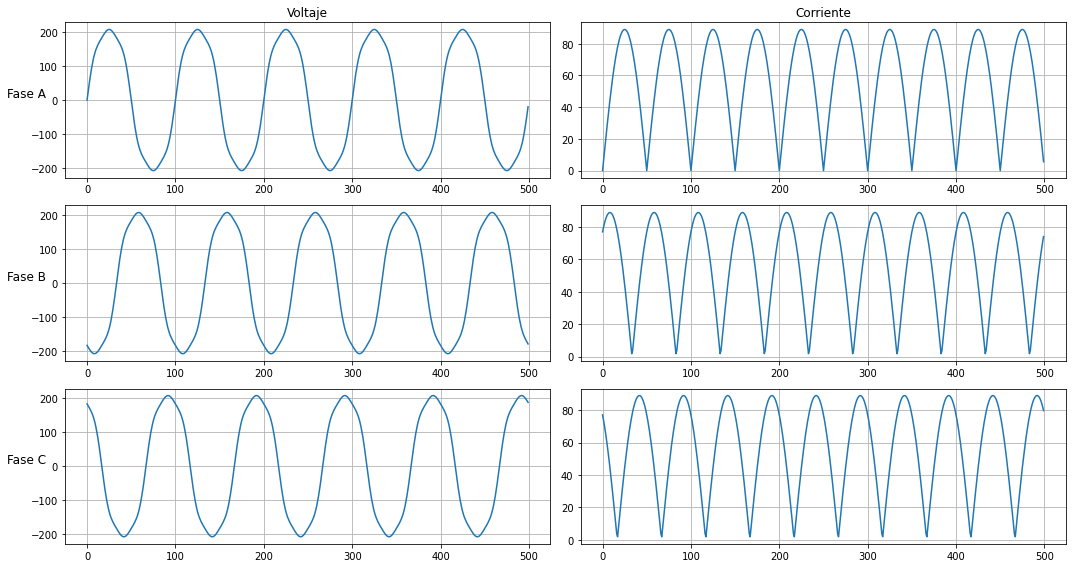

In [21]:
system = DataGen(68)
system.plot()

In [22]:
voltages, currents = system.get_data()

# Obtain every voltage and current value
v1 = voltages[0]
v2 = voltages[1]
v3 = voltages[2]

i1 = currents[0]
i2 = currents[1]
i3 = currents[2]

# Calculate the RMS value of the tensions and currents
v1_rms = round(rmsValue(v1), 4)
v2_rms = round(rmsValue(v2), 4)
v3_rms = round(rmsValue(v3), 4)

i1_rms = round(rmsValue(i1), 4)
i2_rms = round(rmsValue(i2), 4)
i3_rms = round(rmsValue(i3), 4)



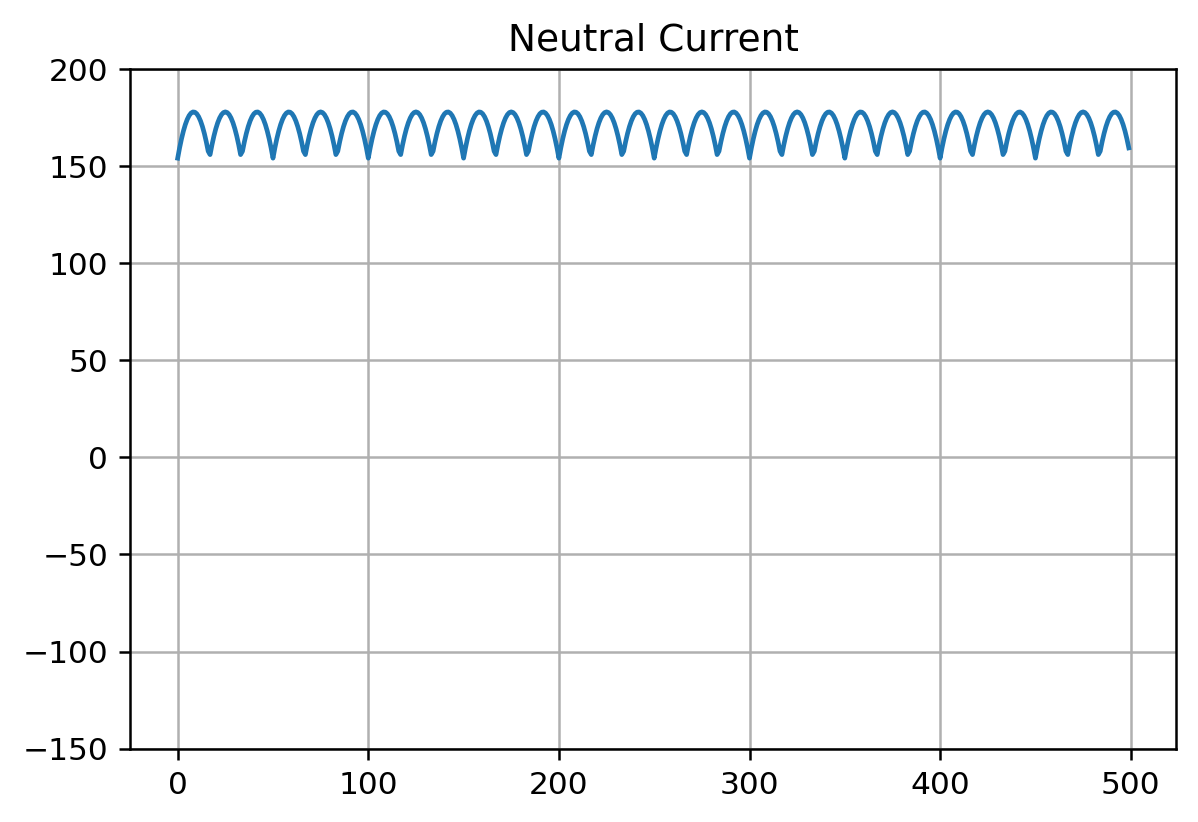

In [27]:
# Calculation and graph of the current in the neutral
i_n = i1 + i2 + i3

ticks = np.arange(-150, 201, 50)

plt.figure(dpi=225)
plt.plot(i_n)
plt.title("Neutral Current")
plt.yticks(ticks)
plt.grid()
plt.show()

In [24]:
# Calculate the power of the system

# Active power for each phase
p1 = round(activePower(v1, i1))
p2 = round(activePower(v2, i2))
p3 = round(activePower(v3, i3))

pt = p1 + p2 + p3

# Apparent power for each phase
s1 = v1_rms * i1_rms
s2 = v2_rms * i2_rms
s3 = v3_rms * i3_rms

# Fryze reactive power for each phase
q1 = reactivePower(v1, i1)
q2 = reactivePower(v2, i2)
q3 = reactivePower(v3, i3)

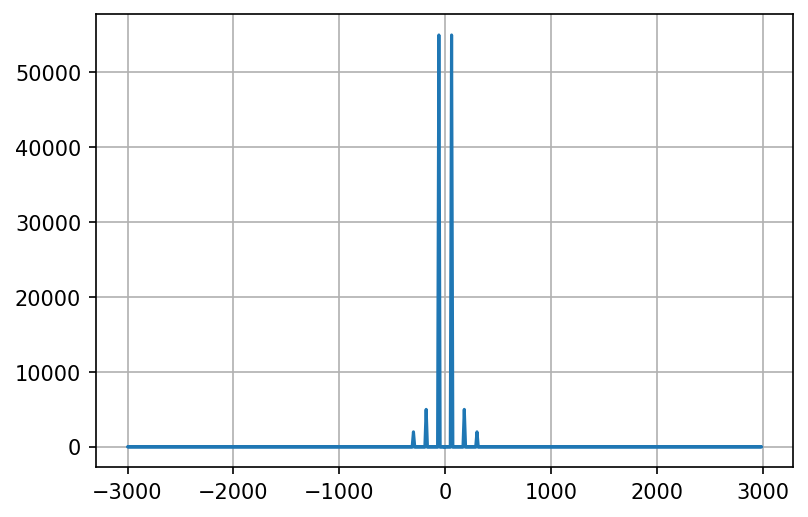

In [25]:
# Fast Fourier Transform
Fs = 6000  # Sample Frequency [Hz]
N = len(v1)  # Amount of data

yf = fft(v1)
xf = fftfreq(N, 1 / Fs)

plt.figure(dpi=150)
plt.plot(xf, np.abs(yf))
plt.grid()
plt.show()

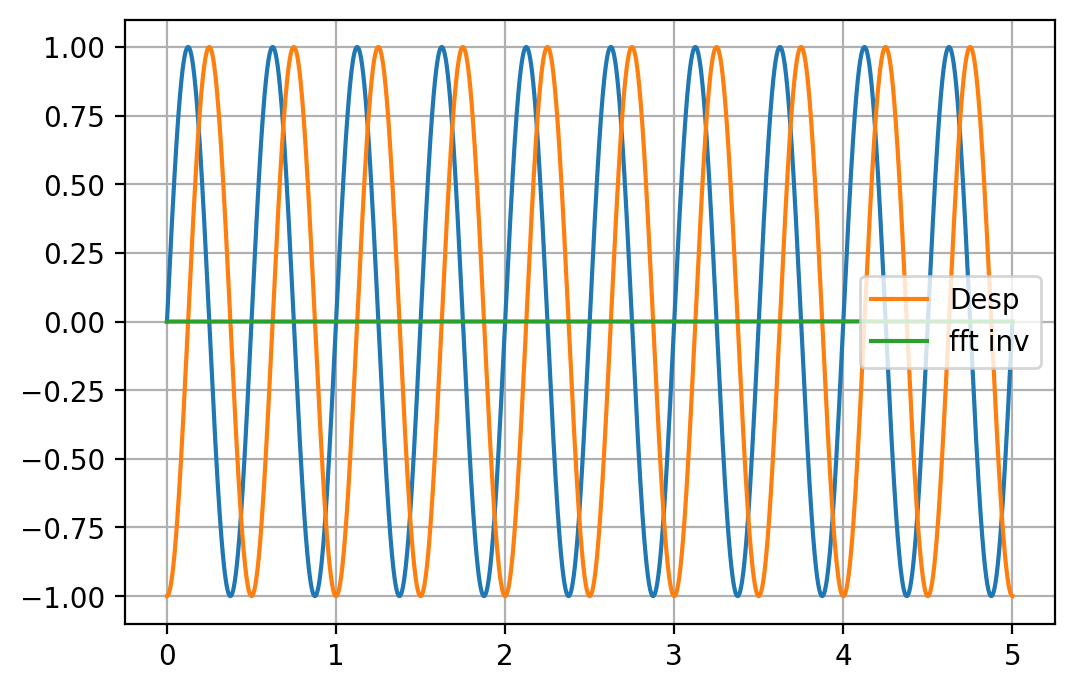

In [26]:
# This cell is used to test some concepts
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds
PHASE = np.pi / 2
N = SAMPLE_RATE * DURATION


def generate_sine_wave(freq, sample_rate, duration, phase=0):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies - phase)
    return x, y


# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
_, yd = generate_sine_wave(2, SAMPLE_RATE, DURATION, PHASE)

yf = fft(y)
xf = fftfreq(N, 1 / SAMPLE_RATE)

wo = 2 * np.pi * 60
ydf = yf  # * np.exp(-xf * ((np.pi / 2)/wo)*(0+1j))

ydt = irfft(ydf)

plt.figure(dpi=200)
plt.plot(x, y)
plt.plot(x, yd, label="Desp")
plt.plot(ydt[:6], label="fft inv")
plt.legend()
plt.grid()
plt.show()